# Direct forecasting with an aeon `BaseForecaster`

Direct forecasting involves repeatedly fitting a forecaster with increasing horizon.
Suppose you have a series of length $n$ and you want to forecast the next 20 steps.

```
for i ← 1 to steps_ahead do
    f ← create forecaster for horizon i
    set f.horizon ← i
    call f.fit(y)
    preds[i - 1] ← f.predict(y)
end for
```
You can visualise the process as follows

<img src="./img/direct.png" width="600" alt="direct forecasting">


We will demonstrate direct forecasting with the airline data

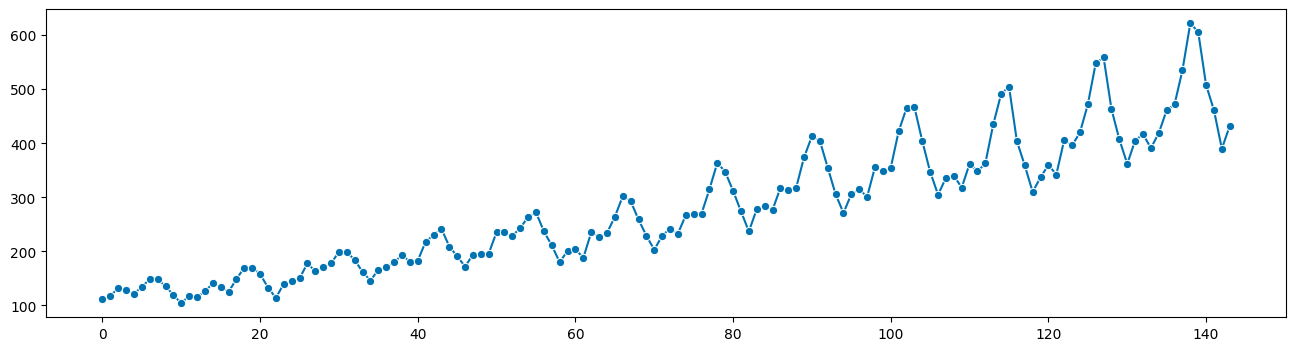

In [1]:
from aeon.datasets import load_airline
from aeon.visualisation import plot_series

airline = load_airline()
_ = plot_series(airline)

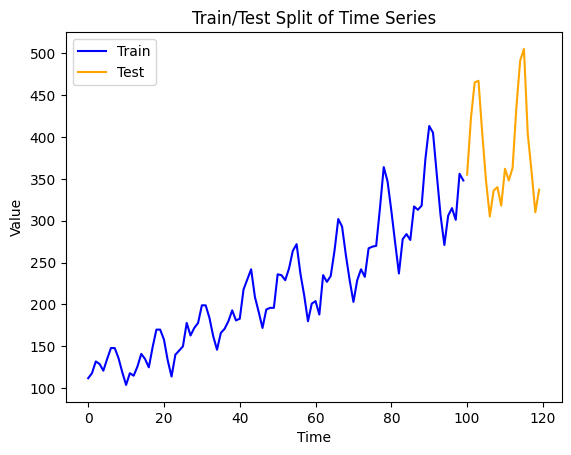

In [2]:
import matplotlib.pyplot as plt
import numpy as np

y_train = airline[:100]
y_test = airline[100:120]
plt.plot(np.arange(0, len(y_train)), y_train, label="Train", color="blue")
plt.plot(
    np.arange(len(y_train), len(y_train) + len(y_test)),
    y_test,
    label="Test",
    color="orange",
)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Train/Test Split of Time Series")
plt.show()

We want to train a forecaster on the train set and forecast predictions for the
subsequent test steps. By default, `aeon` forecasters make a single prediction of the
 `horizon` ahead of the training data. The `RegressionForecaster` is a window based 
 forecaster that by default uses linear regression. It windows across the train data 

In [3]:
from aeon.forecasting import RegressionForecaster

reg = RegressionForecaster(horizon=1, window=10)
reg.forecast(y_train)

376.10513465806844

If we want to predict more than one ahead, the direct strategy involves refiting the 
model with different horizons using the same training data. 

In [4]:
y_hat = np.zeros(20)
temp = y_train.copy()
start = len(y_train)
for i in range(0, 20):
    reg = RegressionForecaster(horizon=i + 1, window=10)
    y_hat[i] = reg.forecast(temp)
    temp = np.append(temp, y_hat[i])
print(y_hat)

[ 376.10513466  453.24184524  410.02884317  320.7916938   345.01419255
  403.67956973  422.56578606  422.96127689  439.10753893  474.27696935
  529.86945212  592.40389602  621.88188642  528.45587755  537.53416799
  615.52150133  704.15649567  781.29311407  940.19098382 1130.45046681]


We have a simple base class function that does this for you called `direct_forecast`

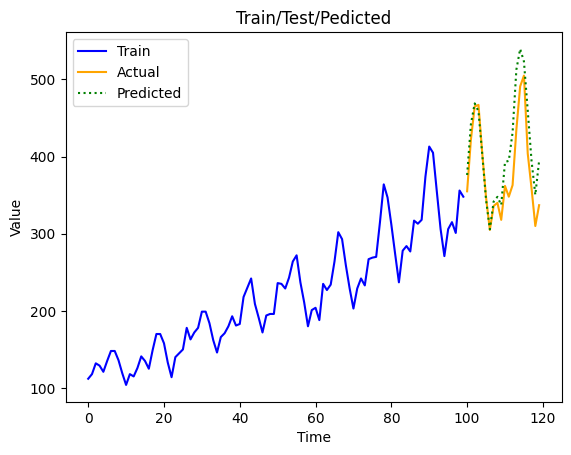

In [6]:
forecaster = RegressionForecaster(window=10)
y_hat = forecaster.direct_forecast(y=y_train, prediction_horizon=20)

plt.plot(np.arange(0, len(y_train)), y_train, label="Train", color="blue")
plt.plot(
    np.arange(len(y_train), len(y_train) + len(y_test)),
    y_test,
    label="Actual",
    color="orange",
)
plt.plot(
    np.arange(len(y_train), len(y_train) + len(y_hat)),
    y_hat,
    label="Predicted",
    color="green",
    linestyle=":",
)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Train/Test/Pedicted")
plt.show()

Differences are clearer if we plot actual vs predicted

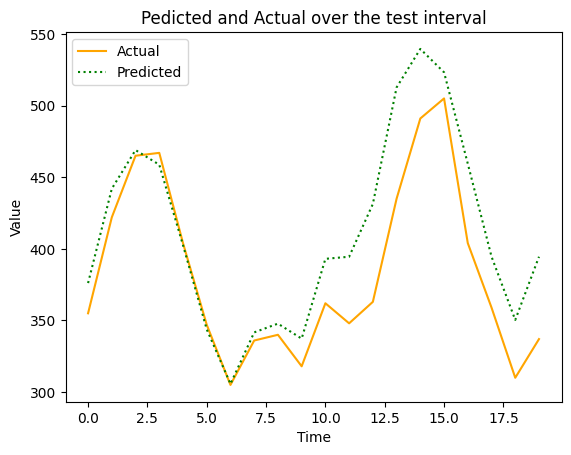

In [7]:
plt.plot(
    y_test,
    label="Actual",
    color="orange",
)
plt.plot(y_hat, label="Predicted", color="green", linestyle=":")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Pedicted and Actual over the test interval")
plt.show()

We see our regressor is consistently predicting higher than the actual values. We can
 see that in the residuals. Another model or some transformation may be appropriate 
 for this data, we are simply showing the mechanism of direct forecasting in `aeon`.

In [8]:
residuals = y_test - y_hat
print(residuals)
mean_squared = np.mean(residuals**2)
print(" MSE  = ", mean_squared)

[-21.10513466 -19.98331603  -3.94966927   8.2686585    1.3881772
   3.18872406  -0.70097463  -5.6727723   -7.79009668 -19.31041562
 -31.02491562 -46.4846751  -68.33857028 -77.68696964 -48.56448463
 -18.22988411 -55.45157724 -35.56987486 -40.37301295 -57.4939017 ]
 MSE  =  1360.1165354697248


Text(0.5, 1.0, 'Residuals over time')

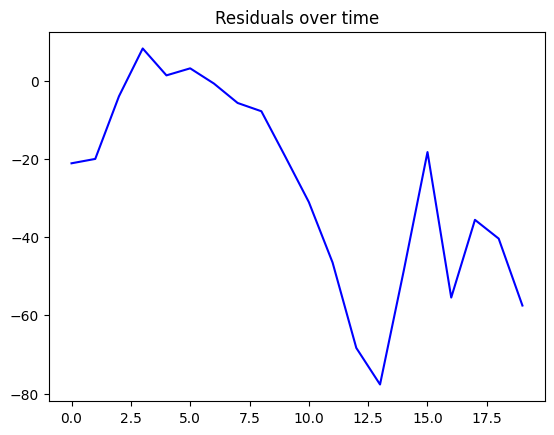

In [9]:
plt.plot(
    residuals,
    label="Residuals",
    color="blue",
)
plt.title("Residuals over time")